### Bibliotecas

In [1]:
"""
%pip install aeon
%pip install tsfresh
%pip install tslearn
%pip install tensorflow
%pip install keras
%pip install pywavelets

"""

'\n%pip install aeon\n%pip install tsfresh\n%pip install tslearn\n%pip install tensorflow\n%pip install keras\n%pip install pywavelets\n\n'

In [2]:
import pandas as pd
import numpy as np

from aeon.datasets import load_classification
from aeon.datasets.tsc_data_lists import univariate_equal_length
from aeon.classification.interval_based import SupervisedTimeSeriesForest, TimeSeriesForestClassifier

#from tsfresh import extract_features, select_features
#from tsfresh.feature_extraction import MinimalFCParameters

from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.piecewise import PiecewiseAggregateApproximation, SymbolicAggregateApproximation

import pywt
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from scipy.fftpack import fft
from numba import jit
import timeit
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

d:\Programas\Anaconda\envs\AM\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


### Loading data

In [3]:
def load_data(dataset):
    # LabelEncoder para labels alvo
    le = LabelEncoder()

    # Carregar conjunto de dados do repositório UCR
    X_train, y_train = load_classification(dataset, split="TRAIN")
    X_test, y_test = load_classification(dataset, split="test")

    # Formatar o conjunto de dados para 2D
    features_train = X_train.reshape(X_train.shape[0], -1)
    features_test = X_test.reshape(X_test.shape[0], -1)

    # Ajustar e transformar as labels alvo
    target_train = le.fit_transform(y_train)
    target_test = le.transform(y_test)

    return features_train, features_test, target_train, target_test


### Function transform data

In [4]:
def choose_wavelet(X):
    min_variance = float('inf')
    best_wavelet = None
    candidate_wavelets = ['db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9']

    for wavelet_type in candidate_wavelets:
        _, coeffs_cD = pywt.dwt(X, wavelet_type, axis=1)
        total_variance = np.var(coeffs_cD)

        if total_variance < min_variance:
            min_variance = total_variance
            best_wavelet = wavelet_type
    return str(best_wavelet)

def transform_data_math(X, wavelet):
    n_sax_symbols = int(X.shape[1] / 4)
    n_paa_segments = int(X.shape[1] / 4)

    X_fft = np.abs(fft(X, axis=1))

    coeffs_cA, coeffs_cD = pywt.dwt(X, wavelet=wavelet, axis=1, mode='constant')
    X_dwt = np.hstack((coeffs_cA, coeffs_cD))

    paa = PiecewiseAggregateApproximation(n_segments=n_paa_segments)
    X_paa_ = paa.inverse_transform(paa.fit_transform(X))
    X_paa = X_paa_.reshape(X_paa_.shape[0], -1)
    df_PAA = pd.DataFrame(X_paa)
    #df_PAA['id'] = range(len(df_PAA))
    
    sax = SymbolicAggregateApproximation(n_segments=n_paa_segments, alphabet_size_avg=n_sax_symbols)
    X_sax_ = sax.inverse_transform(sax.fit_transform(X))
    X_sax = X_sax_.reshape(X_sax_.shape[0], -1)
    df_SAX = pd.DataFrame(X_sax)
    #df_SAX['id'] = range(len(df_SAX))

    data_X = TimeSeriesScalerMeanVariance().fit_transform(X)
    data_X.resize(data_X.shape[0], data_X.shape[1])
    df_X = pd.DataFrame(data_X)
    #df_X['id'] = range(len(df_X))

    data_FFT = TimeSeriesScalerMeanVariance().fit_transform(X_fft)
    data_FFT.resize(data_FFT.shape[0], data_FFT.shape[1])
    df_FFT = pd.DataFrame(data_FFT)
    #df_FFT['id'] = range(len(df_FFT))

    data_DWT = TimeSeriesScalerMeanVariance().fit_transform(X_dwt)
    data_DWT.resize(data_DWT.shape[0], data_DWT.shape[1])
    df_DWT = pd.DataFrame(data_DWT)
    #df_DWT['id'] = range(len(df_DWT))
    
    return {'X': df_X, 'FFT': df_FFT, 'DWT': df_DWT, 'PAA': df_PAA, 'SAX': df_SAX}

def extract_features_from_data(data):
    extracted_features_list = []
    for name, df in data.items():
        features = extract_features(df, default_fc_parameters=MinimalFCParameters(), disable_progressbar=True, column_id='id')
        extracted_features_list.append(features)
    return extracted_features_list

def select_best_features(extracted_features_dict):
    best_features_list = []
    for name, features in extracted_features_dict.items():
        best_features = select_features(features)
        best_features['Method'] = name
        best_features_list.append(best_features)
    concatenated_df = pd.concat(best_features_list, axis=1)
    return concatenated_df.to_numpy() 

### AmazonForestClassifier

In [5]:
class CombinedDecisionForest:
    def __init__(self):
        self.clf1 = RandomForestClassifier()
        self.clf2 = ExtraTreesClassifier()
        self.clf3 = SupervisedTimeSeriesForest()
        self.clf4 = TimeSeriesForestClassifier()
        self.classifiers = [self.clf1, self.clf2, self.clf3, self.clf4]
        self.clf_weights = None

    def fit(self, X, y):
        for clf in self.classifiers:
            clf.fit(X, y)

        train_preds = [clf.predict(X) for clf in self.classifiers]
        accuracies = [accuracy_score(y, preds) for preds in train_preds]

        self.clf_weights = np.array(accuracies)
        self.clf_weights /= np.sum(self.clf_weights)

    def predict_proba(self, X):
        probs = [clf.predict_proba(X) for clf in self.classifiers]
        combined_probs = np.sum([prob * weight for prob, weight in zip(probs, self.clf_weights)], axis=0)
        return combined_probs / np.sum(combined_probs, axis=1, keepdims=True)

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

In [6]:
"""class CombinedDecisionForest:
    def __init__(self):
        self.clf1 = RandomForestClassifier()
        self.clf2 = ExtraTreesClassifier()
        self.clf3 = SupervisedTimeSeriesForest()
        self.clf4 = TimeSeriesForestClassifier()
        self.clf_weights = None

    def fit(self, X, y):
        classifiers = [self.clf1, self.clf2, self.clf3, self.clf4]  # Lista de classificadores

        for clf in classifiers:
            clf.fit(X, y) # Calculando os pesos com base na acurácia
        train_preds = [clf.predict(X) for clf in classifiers]
        accuracies = [accuracy_score(y, preds) for preds in train_preds]

        self.clf_weights = np.array(accuracies) ** 4
        self.clf_weights /= np.sum(self.clf_weights) # Normalização dos pesos

    def predict_proba(self, X):
        classifiers = [self.clf1, self.clf2, self.clf3, self.clf4]  # Lista de classificadores

        probs = [clf.predict_proba(X) for clf in classifiers]
        combined_probs = np.sum([prob * weight for prob, weight in zip(probs, self.clf_weights)], axis=0)

        return combined_probs / np.sum(combined_probs, axis=1, keepdims=True)

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)"""

'class CombinedDecisionForest:\n    def __init__(self):\n        self.clf1 = RandomForestClassifier()\n        self.clf2 = ExtraTreesClassifier()\n        self.clf3 = SupervisedTimeSeriesForest()\n        self.clf4 = TimeSeriesForestClassifier()\n        self.clf_weights = None\n\n    def fit(self, X, y):\n        classifiers = [self.clf1, self.clf2, self.clf3, self.clf4]  # Lista de classificadores\n\n        for clf in classifiers:\n            clf.fit(X, y) # Calculando os pesos com base na acurácia\n        train_preds = [clf.predict(X) for clf in classifiers]\n        accuracies = [accuracy_score(y, preds) for preds in train_preds]\n\n        self.clf_weights = np.array(accuracies) ** 4\n        self.clf_weights /= np.sum(self.clf_weights) # Normalização dos pesos\n\n    def predict_proba(self, X):\n        classifiers = [self.clf1, self.clf2, self.clf3, self.clf4]  # Lista de classificadores\n\n        probs = [clf.predict_proba(X) for clf in classifiers]\n        combined_probs 

### Train/Predict

In [7]:
def train_classifier(X_train, y_train, wavelet=None):
    trained_models = {}  # Salvar modelos treinados para cada transformação
    X_train_transformed = transform_data_math(X_train, wavelet=wavelet)  # Transformar todo o conjunto de treino
    # Treinar um modelo para cada transformação e salvar no dicionário
    for rep, X_trans in X_train_transformed.items():
        model = TimeSeriesForestClassifier()
        model.fit(X_trans, y_train)
        trained_models[rep] = model
        
    # Preparar dados para o meta-classificador
    meta_features = []
    for i in range(X_train.shape[0]):
        instance_features = []
        for rep, model in trained_models.items():
            proba = model.predict_proba(np.array(X_train_transformed[rep].iloc[i,:]).reshape(1, -1))
            instance_features.extend(proba.flatten())
        meta_features.append(instance_features)
    
    meta_features = np.array(meta_features)
    
    meta_classifier = CombinedDecisionForest()
    meta_classifier.fit(meta_features, y_train)
    
    return trained_models, meta_classifier

def predict_classifier(X_test, trained_base_model, trained_meta_classifier, wavelet=None):
    predictions = []
    meta_features_test = []

    for i in tqdm(range(len(X_test)), ascii=True, colour='green', desc="Testing"):
        x_instance = X_test[i].reshape(1, -1)
        x_transformed = transform_data_math(x_instance, wavelet=wavelet)

        instance_features = []
        for rep, X_trans in x_transformed.items():
            proba = trained_base_model[rep].predict_proba(X_trans.values.reshape(1, -1))
            instance_features.extend(proba.flatten())

        meta_feature = np.array(instance_features).reshape(1, -1)
        predictions.append(trained_meta_classifier.predict(meta_feature)[0])

        meta_features_test.append(meta_feature.flatten())

    meta_features_test = np.array(meta_features_test)

    return predictions


### Validando o modelo

In [8]:
dataset_quali_list =  ['ElectricDevices']
dataset_full_list = ['PhalangesOutlinesCorrect','CricketZ','MiddlePhalanxOutlineAgeGroup','ECG5000','ShapeletSim','MiddlePhalanxTW','Symbols','EOGHorizontalSignal','Ham','UMD','HouseTwenty','MiddlePhalanxOutlineCorrect','Wafer','DistalPhalanxTW','CricketY','FacesUCR','FiftyWords','Mallat','Strawberry','ProximalPhalanxOutlineAgeGroup','MixedShapesRegularTrain','SmallKitchenAppliances','GunPointOldVersusYoung','Wine','ProximalPhalanxOutlineCorrect','WordSynonyms', 'RefrigerationDevices','Yoga','CinCECGTorso','ChlorineConcentration','ToeSegmentation1','TwoLeadECG','ProximalPhalanxTW','InsectEPGSmallTrain','WormsTwoClass','PowerCons','InsectEPGRegularTrain','GunPointMaleVersusFemale','DistalPhalanxOutlineCorrect','ItalyPowerDemand','InsectWingbeatSound','NonInvasiveFetalECGThorax2','CricketX','Haptics','EOGVerticalSignal','MixedShapesSmallTrain','Meat','SemgHandGenderCh2','ToeSegmentation2','NonInvasiveFetalECGThorax1','FreezerSmallTrain','OSULeaf','BirdChicken','HandOutlines','BeetleFly','ACSF1','DistalPhalanxOutlineAgeGroup','FreezerRegularTrain']
problematicos = ['Crop','EthanolLevel','ElectricDevices','FordB','ShapesAll','StarLightCurves','Phoneme', 'Computers','InlineSkate','PigAirwayPressure', 'PigCVP','FordA','MedicalImages','PigArtPressure', 'UWaveGestureLibraryX','UWaveGestureLibraryY', 'UWaveGestureLibraryZ', 'UWaveGestureLibraryAll', 'TwoPatterns']

In [9]:
runned = {'Adiac',
'Beef',
'BeetleFly',
'BME',
'Car',
'CBF',
'Coffee',
'Computers',
'Chinatown',
'ChlorineConcentration',
'DistalPhalanxOutlineCorrect',
'DistalPhalanxTW',
'ECG200',
'ECG5000',
'ECGFiveDays',
'EOGHorizontalSignal',
'Earthquakes',
'EthanolLevel',
'FaceFour',
'FacesUCR',
'GunPoint',
'GunPointMaleVersusFemale',
'HandOutlines',
'Lightning2',
'Lightning7',
'MedicalImages',
'MiddlePhalanxOutlineAgeGroup',
'MoteStrain',
'NonInvasiveFetalECGThorax1',
'NonInvasiveFetalECGThorax2',
'OliveOil',
'PigAirwayPressure',
'PowerCons',
'SonyAIBORobotSurface1',
'SonyAIBORobotSurface2',
'ShapeletSim',
'ShapesAll',
'SmoothSubspace',
'SyntheticControl',
'Trace',
'TwoPatterns'}

In [10]:
selected_data = univariate_equal_length - runned

In [11]:
accuracy_data = []
for dataset_name in selected_data:
    features_train, features_test, target_train, target_test = load_data(dataset_name)
    best_wavelet = choose_wavelet(features_train)
    
    trained, clf = train_classifier(features_train, target_train, best_wavelet)
    predictions = predict_classifier(features_test, trained, clf, best_wavelet)

    accuracy = accuracy_score(target_test, predictions)
        
    accuracy_data.append({'Dataset Name': dataset_name, 'Accuracy': accuracy})
    
    print(f"Acurácia {dataset_name}: {accuracy}")
    
accuracy_df = pd.DataFrame(accuracy_data)


Testing: 100%|##########| 455/455 [23:44<00:00,  3.13s/it]


Acurácia FiftyWords: 0.7362637362637363


Testing: 100%|##########| 205/205 [05:46<00:00,  1.69s/it]


Acurácia ProximalPhalanxOutlineAgeGroup: 0.8439024390243902


Testing: 100%|##########| 8236/8236 [7:40:15<00:00,  3.35s/it]  


Acurácia StarLightCurves: 0.9720738222438077


Testing: 100%|##########| 2425/2425 [2:17:30<00:00,  3.40s/it]  


Acurácia MixedShapesRegularTrain: 0.9468041237113402


Testing: 100%|##########| 20/20 [00:47<00:00,  2.37s/it]


Acurácia BirdChicken: 0.9


Testing: 100%|##########| 242/242 [10:33<00:00,  2.62s/it]


Acurácia OSULeaf: 0.7603305785123967


Testing: 100%|##########| 249/249 [10:41<00:00,  2.58s/it]


Acurácia InsectEPGRegularTrain: 1.0


Testing: 100%|##########| 3000/3000 [2:00:25<00:00,  2.41s/it]  


Acurácia Yoga: 0.868


Testing: 100%|##########| 208/208 [17:19<00:00,  5.00s/it]


Acurácia PigCVP: 0.5192307692307693


Testing: 100%|##########| 2850/2850 [1:37:44<00:00,  2.06s/it]


Acurácia FreezerRegularTrain: 0.9968421052631579


Testing: 100%|##########| 450/450 [29:41<00:00,  3.96s/it]


Acurácia SemgHandMovementCh2: 0.8688888888888889


Testing: 100%|##########| 858/858 [22:46<00:00,  1.59s/it]


Acurácia PhalangesOutlinesCorrect: 0.8123543123543123


Testing: 100%|##########| 2345/2345 [2:11:14<00:00,  3.36s/it]  


Acurácia Mallat: 0.9347547974413646


Testing: 100%|##########| 600/600 [35:46<00:00,  3.58s/it]


Acurácia SemgHandGenderCh2: 0.97


Testing: 100%|##########| 105/105 [03:28<00:00,  1.99s/it]


Acurácia Plane: 1.0


Testing: 100%|##########| 205/205 [06:01<00:00,  1.76s/it]


Acurácia ProximalPhalanxTW: 0.824390243902439


Testing: 100%|##########| 7711/7711 [4:13:03<00:00,  1.97s/it]  


Acurácia ElectricDevices: 0.7014654389832706


Testing: 100%|##########| 3582/3582 [2:34:43<00:00,  2.59s/it]  


Acurácia UWaveGestureLibraryY: 0.7219430485762144


Testing: 100%|##########| 3582/3582 [2:34:25<00:00,  2.59s/it]  


Acurácia UWaveGestureLibraryX: 0.7830820770519263


Testing: 100%|##########| 175/175 [05:48<00:00,  1.99s/it]


Acurácia ArrowHead: 0.7714285714285715


Testing: 100%|##########| 139/139 [03:42<00:00,  1.60s/it]


Acurácia DistalPhalanxOutlineAgeGroup: 0.7410071942446043


Testing: 100%|##########| 315/315 [09:02<00:00,  1.72s/it]


Acurácia GunPointOldVersusYoung: 0.9936507936507937


Testing: 100%|##########| 1896/1896 [2:10:01<00:00,  4.11s/it]  


Acurácia Phoneme: 0.19198312236286919


Testing: 100%|##########| 1690/1690 [1:03:38<00:00,  2.26s/it]


Acurácia FaceAll: 0.827810650887574


Testing: 100%|##########| 54/54 [01:45<00:00,  1.95s/it]


Acurácia Wine: 0.6481481481481481


Testing: 100%|##########| 144/144 [04:16<00:00,  1.78s/it]


Acurácia UMD: 0.875


Testing: 100%|##########| 119/119 [07:38<00:00,  3.85s/it]


Acurácia HouseTwenty: 0.907563025210084


Testing: 100%|##########| 375/375 [18:30<00:00,  2.96s/it]


Acurácia ScreenType: 0.528


Testing: 100%|##########| 77/77 [04:07<00:00,  3.22s/it]


Acurácia Worms: 0.6623376623376623


Testing: 100%|##########| 208/208 [17:05<00:00,  4.93s/it]


Acurácia PigArtPressure: 0.7403846153846154


Testing: 100%|##########| 291/291 [07:40<00:00,  1.58s/it]


Acurácia ProximalPhalanxOutlineCorrect: 0.865979381443299


Testing: 100%|##########| 3582/3582 [2:34:44<00:00,  2.59s/it]  


Acurácia UWaveGestureLibraryZ: 0.7546063651591289


Testing: 100%|##########| 375/375 [18:32<00:00,  2.97s/it]


Acurácia RefrigerationDevices: 0.5653333333333334


Testing: 100%|##########| 291/291 [07:41<00:00,  1.58s/it]


Acurácia MiddlePhalanxOutlineCorrect: 0.8178694158075601


Testing: 100%|##########| 1029/1029 [20:50<00:00,  1.22s/it]


Acurácia ItalyPowerDemand: 0.9533527696793003


Testing: 100%|##########| 50/50 [03:50<00:00,  4.61s/it]


Acurácia Rock: 0.9


Testing: 100%|##########| 249/249 [10:33<00:00,  2.54s/it]


Acurácia InsectEPGSmallTrain: 1.0


Testing: 100%|##########| 2850/2850 [1:36:28<00:00,  2.03s/it]


Acurácia FreezerSmallTrain: 0.9729824561403508


Testing: 100%|##########| 625/625 [23:24<00:00,  2.25s/it]


Acurácia SwedishLeaf: 0.9408


Testing: 100%|##########| 1380/1380 [1:25:22<00:00,  3.71s/it]


Acurácia CinCECGTorso: 0.9905797101449275


Testing: 100%|##########| 638/638 [29:12<00:00,  2.75s/it]


Acurácia WordSynonyms: 0.5532915360501567


Testing: 100%|##########| 3582/3582 [3:29:22<00:00,  3.51s/it]  


Acurácia UWaveGestureLibraryAll: 0.954215522054718


Testing: 100%|##########| 316/316 [09:11<00:00,  1.75s/it]


Acurácia GunPointAgeSpan: 0.9968354430379747


Testing: 100%|##########| 130/130 [04:34<00:00,  2.11s/it]


Acurácia ToeSegmentation2: 0.8615384615384616


Testing: 100%|##########| 370/370 [12:29<00:00,  2.02s/it]


Acurácia Strawberry: 0.9567567567567568


Testing: 100%|##########| 390/390 [17:02<00:00,  2.62s/it]


Acurácia CricketZ: 0.6641025641025641


Testing: 100%|##########| 390/390 [17:05<00:00,  2.63s/it]


Acurácia CricketY: 0.7


Testing: 100%|##########| 100/100 [06:29<00:00,  3.89s/it]


Acurácia ACSF1: 0.75


Testing: 100%|##########| 6164/6164 [2:58:30<00:00,  1.74s/it]  


Acurácia Wafer: 0.9975665152498377


Testing: 100%|##########| 175/175 [07:54<00:00,  2.71s/it]


Acurácia Fish: 0.84


Testing: 100%|##########| 308/308 [17:38<00:00,  3.44s/it]


Acurácia Haptics: 0.487012987012987


Testing: 100%|##########| 60/60 [02:21<00:00,  2.36s/it]


Acurácia Meat: 0.9166666666666666


Testing: 100%|##########| 375/375 [18:17<00:00,  2.93s/it]


Acurácia SmallKitchenAppliances: 0.8186666666666667


Testing: 100%|##########| 16800/16800 [9:21:19<00:00,  2.00s/it]  


Acurácia Crop: 0.7372619047619048


Testing: 100%|##########| 64/64 [02:36<00:00,  2.45s/it]


Acurácia Herring: 0.59375


Testing: 100%|##########| 2425/2425 [2:12:17<00:00,  3.27s/it]  


Acurácia MixedShapesSmallTrain: 0.9014432989690722


Testing: 100%|##########| 375/375 [19:23<00:00,  3.10s/it]


Acurácia LargeKitchenAppliances: 0.632


Testing: 100%|##########| 810/810 [38:09<00:00,  2.83s/it]


Acurácia FordB: 0.7679012345679013


Testing: 100%|##########| 228/228 [08:17<00:00,  2.18s/it]


Acurácia ToeSegmentation1: 0.8464912280701754


Testing: 100%|##########| 1320/1320 [59:30<00:00,  2.70s/it] 


Acurácia FordA: 0.9477272727272728


Testing: 100%|##########| 362/362 [23:27<00:00,  3.89s/it]


Acurácia EOGVerticalSignal: 0.47790055248618785


Testing: 100%|##########| 1980/1980 [1:22:12<00:00,  2.49s/it]


Acurácia InsectWingbeatSound: 0.6419191919191919


Testing: 100%|##########| 390/390 [17:02<00:00,  2.62s/it]


Acurácia CricketX: 0.6487179487179487


Testing: 100%|##########| 105/105 [04:02<00:00,  2.31s/it]


Acurácia Ham: 0.7238095238095238


Testing: 100%|##########| 995/995 [39:37<00:00,  2.39s/it]


Acurácia Symbols: 0.9296482412060302


Testing: 100%|##########| 306/306 [11:23<00:00,  2.23s/it]


Acurácia DiatomSizeReduction: 0.954248366013072


Testing: 100%|##########| 77/77 [03:52<00:00,  3.02s/it]


Acurácia WormsTwoClass: 0.8311688311688312


Testing: 100%|##########| 154/154 [04:33<00:00,  1.78s/it]


Acurácia MiddlePhalanxTW: 0.538961038961039


Testing: 100%|##########| 1139/1139 [28:36<00:00,  1.51s/it]


Acurácia TwoLeadECG: 0.8788410886742757


Testing: 100%|##########| 550/550 [38:24<00:00,  4.19s/it]


Acurácia InlineSkate: 0.44727272727272727


Testing: 100%|##########| 450/450 [28:52<00:00,  3.85s/it]

Acurácia SemgHandSubjectCh2: 0.9488888888888889


In [12]:
accuracy_df
accuracy_df.to_csv('ModelAM_FeatureWorking.csv')

### DynamicAmazonClassifier

In [13]:
from sklearn.linear_model import RidgeClassifierCV

accuracy_data = []
for dataset_name in univariate_equal_length:
    # Carregue os dados de treinamento e teste
    features_train, features_test, target_train, target_test = load_data(dataset_name)
    best_wavelet = choose_wavelet(features_train)
    
    feature_extractor = CombinedDecisionForest()
    feature_extractor.fit(features_train, target_train)
    
    train_features = feature_extractor.predict_proba(features_train)
    test_features = feature_extractor.predict_proba(features_test)
    
    meta_model = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
    
    meta_model.fit(train_features, target_train)
    
    predictions = meta_model.predict(test_features)
    
    accuracy = accuracy_score(target_test, predictions)
        
    accuracy_data.append({'Dataset Name': dataset_name, 'Accuracy': accuracy})
    
    print(f"Accuracy {dataset_name}: {accuracy}")
    
accuracy_df = pd.DataFrame(accuracy_data)

Accuracy PigAirwayPressure: 0.2403846153846154
Accuracy FiftyWords: 0.7538461538461538
Accuracy ProximalPhalanxOutlineAgeGroup: 0.8585365853658536
Accuracy StarLightCurves: 0.9720738222438077
Accuracy NonInvasiveFetalECGThorax1: 0.9124681933842239
Accuracy BME: 1.0
Accuracy Mallat: 0.95863539445629
Accuracy Lightning2: 0.7868852459016393
Accuracy Plane: 0.9904761904761905
Accuracy SonyAIBORobotSurface1: 0.8685524126455907
Accuracy ProximalPhalanxTW: 0.8146341463414634
Accuracy UWaveGestureLibraryX: 0.8115577889447236
Accuracy ShapesAll: 0.8433333333333334
Accuracy ArrowHead: 0.6971428571428572
Accuracy DistalPhalanxOutlineAgeGroup: 0.762589928057554
Accuracy GunPointOldVersusYoung: 1.0
Accuracy Phoneme: 0.27531645569620256
Accuracy Wine: 0.7222222222222222
Accuracy UMD: 0.9930555555555556
Accuracy Worms: 0.6363636363636364
Accuracy UWaveGestureLibraryZ: 0.7537688442211056
Accuracy ProximalPhalanxOutlineCorrect: 0.8797250859106529
Accuracy BeetleFly: 0.95
Accuracy MiddlePhalanxOutlineCo

In [14]:
accuracy_df

,Dataset Name,Accuracy
0,PigAirwayPressure,0.240385
1,FiftyWords,0.753846
2,ProximalPhalanxOutlineAgeGroup,0.858537
3,StarLightCurves,0.972074
4,NonInvasiveFetalECGThorax1,0.912468
...,...,...
107,Symbols,0.943719
108,Crop,0.772440
109,WormsTwoClass,0.714286
110,InlineSkate,0.410909


In [15]:
accuracy_df.to_csv('ModelAM_FeatureWorking.csv')

### Representação temporal de uma transformada rápida de Fourier

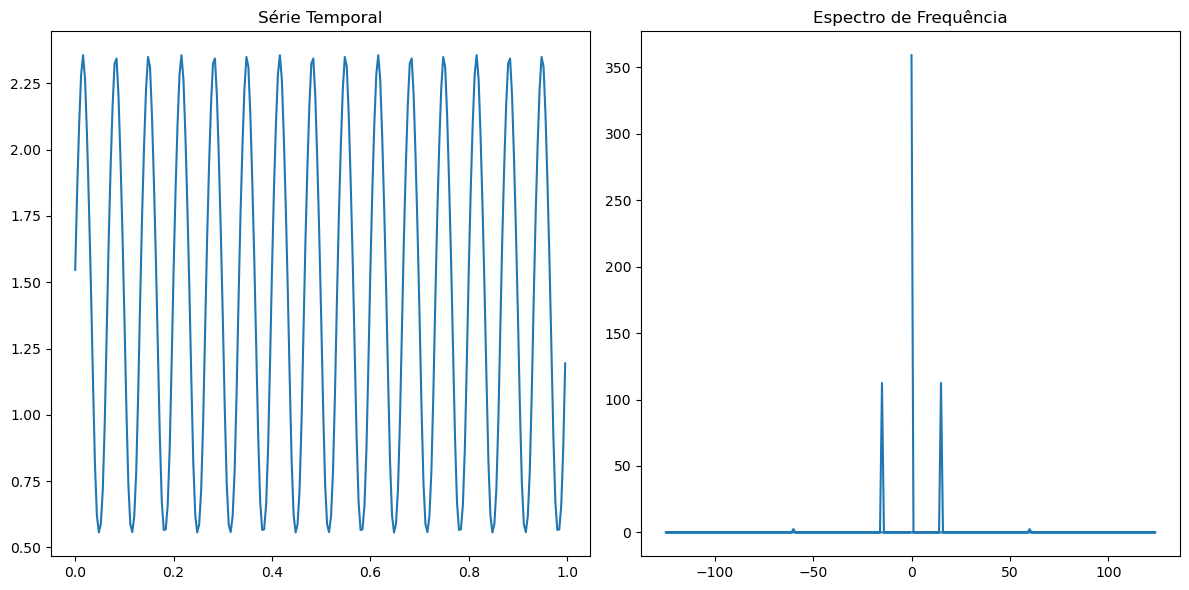

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Criação dos dados
t = np.linspace(0, 1, 250, endpoint=False)
a = 0.02
f = 5
x = 0.9 * np.sin(2 * np.pi * 3 * f * t + .1)
x += a * np.cos(2 * np.pi * 312 * f * t + .1)
x += a * np.cos(2 * np.pi * 2000 * f * t)
x += a * np.sin(2 * np.pi * 5000 * f * t)
x += 0.8 * np.cos(2 * np.pi * 2.3e4 * f * t)
x += 0.3 * np.cos(2 * np.pi * 1.3e5 * f * t + .1)
x += 0.3 * np.cos(2 * np.pi * 2.3e5 * f * t + .1)
x += a * np.cos(2 * np.pi * 2e6 * f * t)

# Transformada de Fourier
y = np.fft.fft(x)
freq = np.fft.fftfreq(len(x), d=t[1] - t[0])

# Plotagem do gráfico
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(t, x)
plt.title('Série Temporal')

plt.subplot(122)
plt.plot(freq, np.abs(y))
plt.title('Espectro de Frequência')

plt.tight_layout()
plt.show()
